<a href="https://colab.research.google.com/github/tanu-yadav00/tanu_cognorise_infotech/blob/main/fake_news_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import lightgbm as lgb
import re, string

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from xgboost import XGBClassifier
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

data pre processing

In [2]:
df = pd.read_csv('/content/news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


dataset review

In [3]:
df.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)

In [4]:
df.isnull().sum()

ID       0
title    0
text     0
label    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


[Text(0, 0, '3164'), Text(0, 0, '3171')]

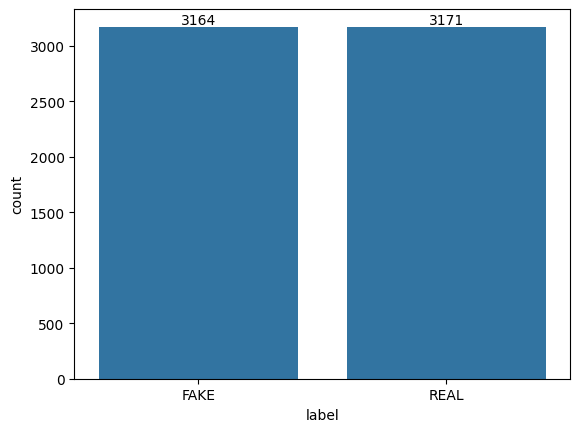

In [6]:
# Are classes balanced?
ax = sns.countplot(x = df['label'])
ax.bar_label(ax.containers[0])


In [7]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


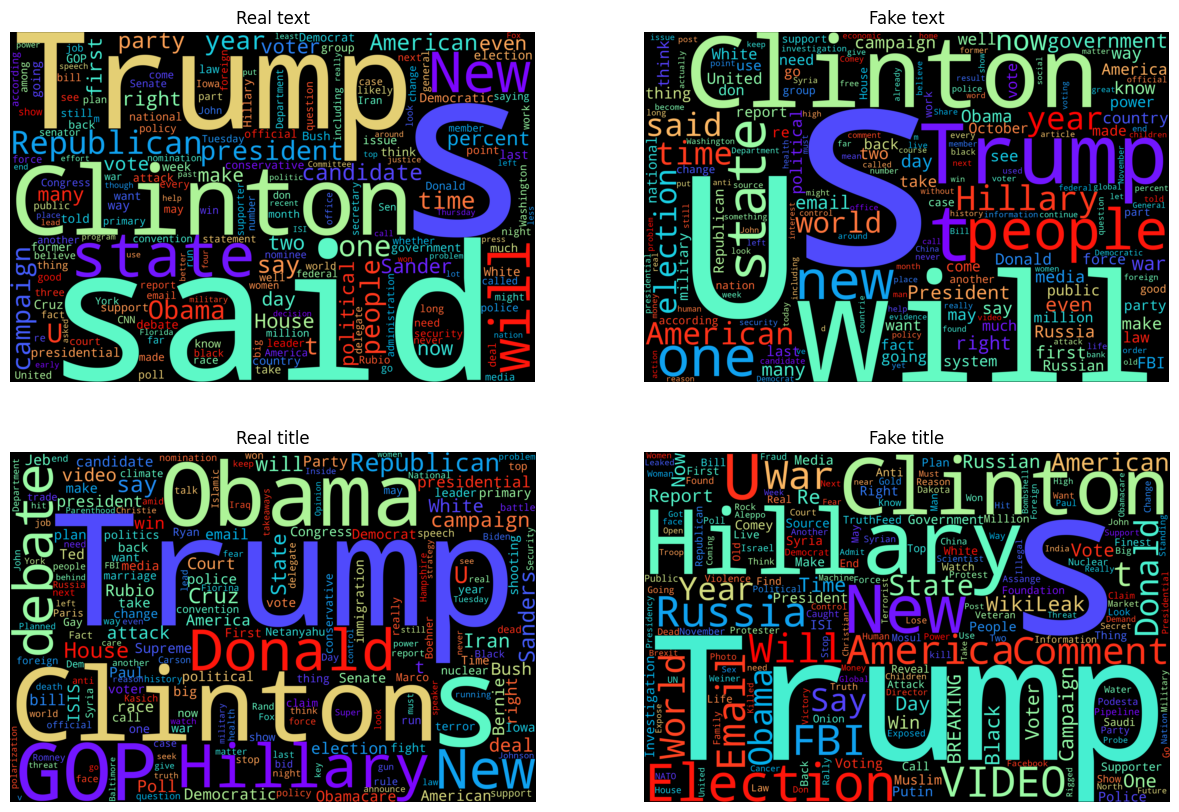

In [8]:
text_real = " ".join(df[df['label'] == 'REAL']['text'].astype(str))
text_fake = " ".join(df[df['label'] == 'FAKE']['text'].astype(str))

title_real = " ".join(df[df['label'] == 'REAL']['title'].astype(str))
title_fake = " ".join(df[df['label'] == 'FAKE']['title'].astype(str))

wordcloud_real_text = WordCloud(
    width = 3000, height = 2000, random_state = 1, background_color = 'black', colormap = 'rainbow',
    collocations = False, stopwords = STOPWORDS
).generate(text_real)

wordcloud_fake_text = WordCloud(
    width = 3000, height = 2000, random_state = 1, background_color = 'black', colormap = 'rainbow',
    collocations = False, stopwords = STOPWORDS
).generate(text_fake)

wordcloud_real_title = WordCloud(
    width = 3000, height = 2000, random_state = 1, background_color = 'black', colormap = 'rainbow',
    collocations = False, stopwords = STOPWORDS
).generate(title_real)

wordcloud_fake_title = WordCloud(
    width = 3000, height = 2000, random_state = 1, background_color = 'black', colormap = 'rainbow',
    collocations = False, stopwords = STOPWORDS
).generate(title_fake)

fig = plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_real_text, interpolation = 'bilinear')
plt.title('Real text')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_fake_text, interpolation = 'bilinear')
plt.title('Fake text')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_real_title, interpolation = 'bilinear')
plt.title('Real title')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_fake_title, interpolation = 'bilinear')
plt.title('Fake title')
plt.axis('off')
plt.show()

In [9]:
# Set data and target
X = df['text']
y = df['label'].map({'REAL': 0, 'FAKE': 1})

# Train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
print(f'X_train shape: {X_train.shape} \ny_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape} \ny_test shape: {y_test.shape}')

X_train shape: (5068,) 
y_train shape: (5068,)
X_test shape: (1267,) 
y_test shape: (1267,)


In [11]:
# Vectorize
vectorizer = CountVectorizer(dtype = np.float32)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [12]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

results_no_feat_eng = {}
for name, model in tqdm(models.items()):
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_test_vectorized)

    results_no_feat_eng[name] = accuracy_score(y_test, predictions)

100%|██████████| 5/5 [10:27<00:00, 125.52s/it]


In [13]:
results_no_feat_eng = pd.DataFrame(results_no_feat_eng, index = ['accuracy of model with no Feature Engineering']).T

feature engineering

In [14]:
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    return text

df['cleaned_text'] = df['text'].apply(clean)
df['cleaned_title'] = df['title'].apply(clean)
df.head()

,ID,title,text,label,cleaned_text,cleaned_title
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,daniel greenfield shillman journal fellow free...,smell hillary’ fear
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,googl pinterest digg linkedin reddit stumbleup...,watch exact moment paul ryan commit polit suic...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,us secretari state john f kerri said monday st...,kerri go pari gestur sympathi
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,— kayde king kaydeek novemb lesson tonight d...,berni support twitter erupt anger dnc tri warn
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,primari day new york frontrunn hillari clinton...,battl new york primari matter


In [15]:
# Set data and target
X = df['cleaned_text'] + ' ' + df['cleaned_title']
y = df['label'].map({'REAL': 0, 'FAKE': 1})

# Train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
print(f'X_train shape: {X_train.shape} \ny_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape} \ny_test shape: {y_test.shape}')

X_train shape: (5068,) 
y_train shape: (5068,)
X_test shape: (1267,) 
y_test shape: (1267,)


In [17]:
# Vectorize
vectorizer = CountVectorizer(dtype = np.float32)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [18]:
models = {
  'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Light XGBoost': lgb.LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'Passive Aggressive': PassiveAggressiveClassifier()
}

results_feat_eng = {}
for name, model in tqdm(models.items()):
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_test_vectorized)

    results_feat_eng[name] = accuracy_score(y_test, predictions)

 62%|██████▎   | 5/8 [06:26<05:34, 111.45s/it]

[LightGBM] [Info] Number of positive: 2536, number of negative: 2532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35238
[LightGBM] [Info] Number of data points in the train set: 5068, number of used features: 6635
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500395 -> initscore=0.001579
[LightGBM] [Info] Start training from score 0.001579


100%|██████████| 8/8 [06:48<00:00, 51.07s/it]


results summary

In [19]:
results_feat_eng = pd.DataFrame(results_feat_eng, index = ['accuracy of model with Feature Engineering']).T

In [20]:
results = pd.merge(results_no_feat_eng, results_feat_eng, left_index = True, right_index = True)\
.style.highlight_max(color = 'green')\
.highlight_min(color = 'red')

results

,accuracy of model with no Feature Engineering,accuracy of model with Feature Engineering
Random Forest,0.894238,0.909234
Support Vector Machine,0.855564,0.877664
Naive Bayes,0.898974,0.900552
Logistic Regression,0.918706,0.924230
k-Nearest Neighbors,0.814522,0.820047


Improving the parameters of the best model with Optuna

In [21]:
!pip install optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00


In [27]:
def objective(trial):
    params = {
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 9, 2),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    }

    model = lgb.LGBMClassifier(**params, random_state = 51, n_estimators = 3000, device = 'cpu', n_jobs = -1)

    scores = []
    model.fit(X_train_vectorized, y_train, eval_metric = 'acc',
              eval_set = [(X_train_vectorized, y_train), (X_test_vectorized, y_test)], )
    preds = model.predict(X_test_vectorized)

    score = accuracy_score(y_test, preds)
    scores.append(score)

    return sum(scores)

In [28]:
!apt-get install nvidia-driver-460 nvidia-cuda-toolkit clinfo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clinfo is already the newest version (3.0.21.02.21-1).
Some packages could not be installed. This may mean that you have
requested an impossible situation or if you are using the unstable
distribution that some required packages have not yet been created
or been moved out of Incoming.
The following information may help to resolve the situation:

The following packages have unmet dependencies:
 libnvidia-compute-510 : Depends: libnvidia-compute-525 but it is not installable
 nvidia-cuda-dev : Breaks: libcuda1 (< 495)
                   Recommends: libnvcuvid1 but it is not installable
E: Unable to correct problems, you have held broken packages.


In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = 50)


In [30]:
params = study.best_params
params

{'subsample': 0.8,
 'colsample_bytree': 0.8,
 'max_depth': 5,
 'learning_rate': 0.02314016067702242}

10-cross validation

In [ ]:
from sklearn.model_selection import KFold

model = lgb.LGBMClassifier(**params, n_estimators = 4000, device = 'cpu', n_jobs = -1)

scores = []
cv = KFold(n_splits = 10, shuffle = True)

for train_idx, test_idx in cv.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model.fit(X_train_vec, y_train,eval_metric = 'acc',
              eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)])

    preds = model.predict(X_test_vec)
    score = accuracy_score(y_test, preds)
    scores.append(score)

In [33]:
print('************************************')

for i in range(cv.get_n_splits()):
    print(f' Acc fold {i}:     {scores[i - 1]}')

print('************************************')
print(f"Mean acc score:       {np.mean(scores)}")
print(f"Std acc:              {np.std(scores)}")

************************************
 Acc fold 0:     0.9210110584518167
 Acc fold 1:     0.944794952681388
 Acc fold 2:     0.9353312302839116
 Acc fold 3:     0.9069400630914827
 Acc fold 4:     0.9337539432176656
 Acc fold 5:     0.9337539432176656
 Acc fold 6:     0.9352290679304898
 Acc fold 7:     0.9399684044233807
 Acc fold 8:     0.9289099526066351
 Acc fold 9:     0.9399684044233807
************************************
Mean acc score:       0.9319661020327817
Std acc:              0.010376283232128473


summary of model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2536, number of negative: 2532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.416958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35238
[LightGBM] [Info] Number of data points in the train set: 5068, number of used features: 6635
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500395 -> initscore=0.001579
[LightGBM] [Info] Start training from score 0.001579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

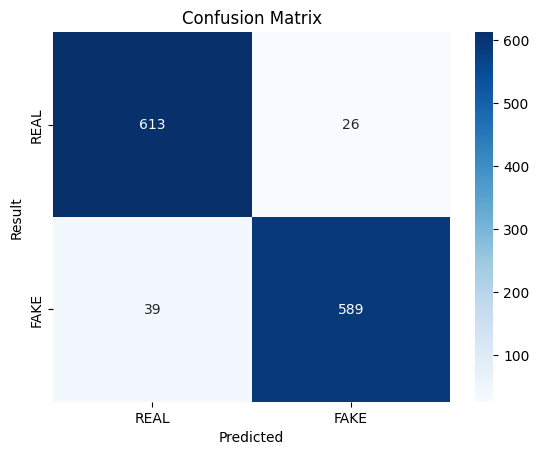

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)
preds_test = model.predict(X_test_vectorized)

conf_matrix = confusion_matrix(y_test, preds_test)

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['REAL', 'FAKE'], yticklabels = ['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Result')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print(f'Accuracy:     {accuracy_score(y_test, preds_test)}')
print(f'Precision:    {precision_score(y_test, preds_test)}')
print(f'Recall:       {recall_score(y_test, preds_test)}')
print(f'f1:           {f1_score(y_test, preds_test)}')
print(f'Auroc:        {roc_auc_score(y_test, preds_test)}')

Accuracy:     0.9486977111286503
Precision:    0.9577235772357724
Recall:       0.9378980891719745
f1:           0.9477071600965405
Auroc:        0.9486047566360654


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


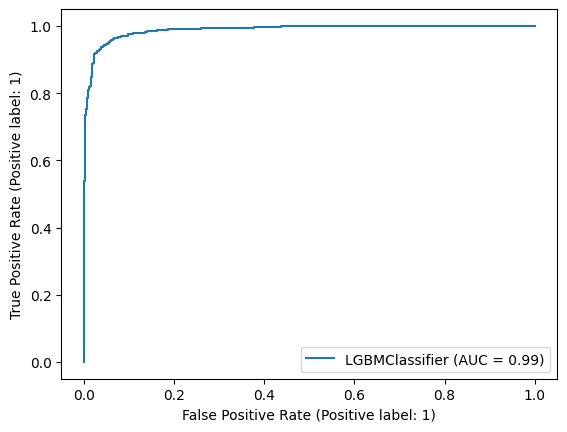

In [36]:
RocCurveDisplay.from_estimator(model, X_test_vectorized, y_test)

In [37]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       639
           1       0.96      0.94      0.95       628

    accuracy                           0.95      1267
   macro avg       0.95      0.95      0.95      1267
weighted avg       0.95      0.95      0.95      1267

